# Bayesian Machine Learning

## Antoine Ratouchniak - Louise Allain

### Closing the gap between the modes

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

sns.set_palette("husl")

from utils import *
from NVAE import *
import torchvision
device = "cuda:0" if torch.cuda.is_available() else "cpu"

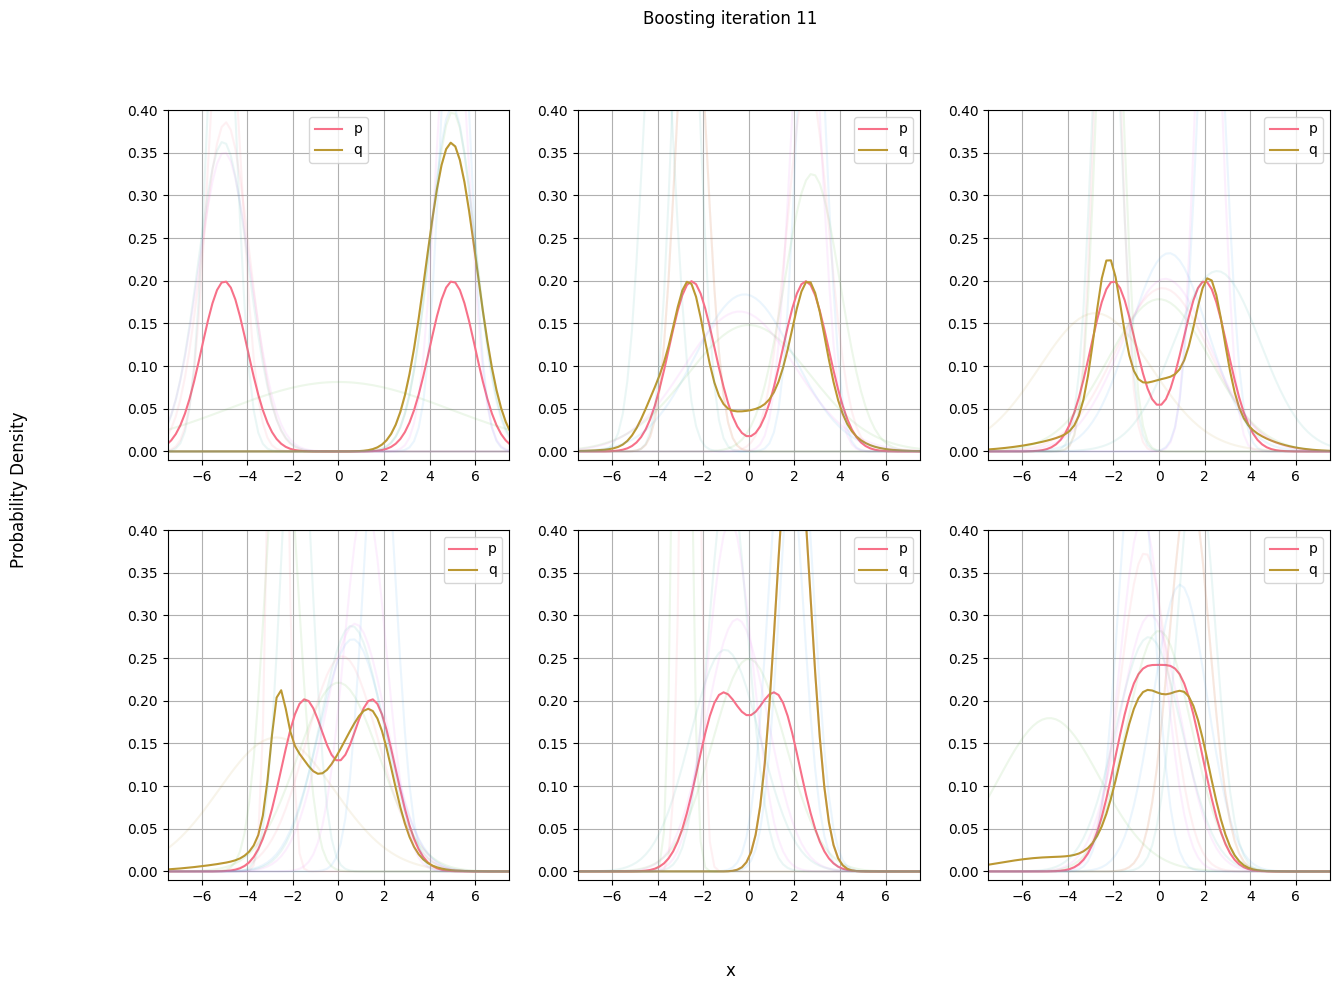

In [2]:
mus = [5, 2.5, 2, 1.5, 1.25, 1]
x = torch.linspace(-20, 20, 200)
sigma = torch.tensor(1.0, requires_grad=False)
alpha = torch.tensor(0.5, requires_grad=False)
boosting_iterations = 11

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Boosting iteration {boosting_iterations}')
fig.supxlabel('x')
fig.supylabel('Probability Density')
for i, mu in enumerate(mus):
    mu_pos = torch.tensor(mu, requires_grad = False)
    mu_neg = torch.tensor(-mu, requires_grad = False)
    p = bimodal_distribution(x, mu_neg, sigma, mu_pos, sigma, alpha)
    fi, qi = vi_fkl(x, p, boosting_iterations=boosting_iterations)
    with torch.no_grad():
        ax[1*(i>2)][i%3].plot(x.numpy(), p, label='p')
        ax[1*(i>2)][i%3].plot(x.numpy(), fi, label='q')
        if(len(qi) > 1):
            for k in range(len(qi)):
                ax[1*(i>2)][i%3].plot(x.numpy(), qi[k].detach(), alpha=0.1)
        ax[1*(i>2)][i%3].legend()
        ax[1*(i>2)][i%3].set_xlim(-7.5, 7.5)
        ax[1*(i>2)][i%3].set_ylim(-.01, .4)
        ax[1*(i>2)][i%3].grid()

### NVAE model using the forward KL

Adapted from https://github.com/GlassyWing/nvae based on NVAE official implementation https://github.com/NVlabs/NVAE

In [3]:
# load MNIST dataset
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)

$\newcommand{\bx}{\mathbf{x}} % bold x$
$\newcommand{\bz}{\mathbf{z}} % bold z$
$\newcommand{\DKL}{D_{\mathrm{KL}}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\bmu}{{\mathbf{\mu}}} % bold mu$
$\newcommand{\bsigma}{{\mathbf{\sigma}}} % bold Sigma$
$\newcommand{\diag}{\operatorname{diag}}$

The training loss for the hierarchical VAE is
$$
    \mathcal{L}_{\text{VAE}}(\bx) :
    = \E_{q(\bz|\bx)}\left[ \log p(\bx|\bz) \right] - \DKL(q(\bz_1|\bx)||p(\bz_1)) - \sum_{l=2}^L \E_{q(\bz_{<l}|\bx)} \left[ \DKL(q(\bz_l|\bx, \bz_{<l})||p(\bz_l|\bz_{<l})) \right]
$$

We change it to $\require{color}$
$$\mathcal{L}_{\text{VAE}}(\bx) :
    = \E_{q(\bz|\bx)}\left[ \log p(\bx|\bz) \right] - \DKL(q(\bz_1|\bx)|p(\bz_1)) - \sum_{l=2}^L \E_{q(\bz_{<l}|\bx)} \left[ \textcolor{orange}{\DKL(p(\bz_l|\bz_{<l})||q(\bz_l|\bx, \bz_{<l}))} \right]$$

Following the NVAE paper, we suppose that
$
p(\bz_l|\bz_{<l}) = \mathcal{N} \left(\bmu(\bz_{<l}), \diag{\bsigma^2}(\bz_{<l}) \right)
$
and
$$
q(\bz_l|\bz_{<l}, \bx) = \mathcal{N} \left(\bmu(\bz_{<l}) + \Delta \bmu(\bz_{<l}, \bx), \diag\left(\bsigma^2(\bz_{<l}) \cdot \Delta \bsigma^2(\bz_{<l}, \bx)\right) \right).
$$

Then, we can derive a closed formula as
$$D_{\text{KL}}(q(\bz_l|\bx, \bz_{<l})||p(\bz_l|\bz_{<l})) = \mathbb E_{z \sim q(\bz_l | \bx, \bz_{< l})}[\log \frac{q(\bz | \bx, \bz_{< l})}{p(\bz_l | \bz_{< l})}] = \frac{1}{2}\left(\frac{\lVert \bmu(\bz_{< l}) + \Delta \bmu(\bz_{< l}) - \bmu(\bz_{< l}\rVert^2}{\bsigma^2(\bz_{< l})} + \frac{\bsigma^2(\bz_{< l}) \cdot \Delta \bsigma^2(\bz_{< l}, x)}{\bsigma^2(\bz_{< l})} - \log\left(\frac{\bsigma^2(\bz_{< l}) \cdot \Delta \bsigma^2(\bz_{< l}, x)}{\bsigma^2(\bz_{< l})}\right) - 1\right) =
\frac{1}{2}\left(\frac{\lVert \Delta \bmu(\bz_{< l}) \rVert^2}{\bsigma^2(\bz_{< l})} + \Delta \bsigma^2(\bz_{< l}, x) - \log (\Delta \bsigma^2(\bz_{< l}, x)) - 1\right)$$

Similarly, it is possible to show that
$$D_{\text{KL}}(p(\bz_l|\bz_{<l})||q(\bz_l|\bx, \bz_{<l})) =
\frac{1}{2}\left(\frac{\lVert \Delta \bmu(\bz_{< l}) \rVert^2}{\bsigma^2(\bz_{< l}) \cdot \Delta \bsigma^2(\bz_{< l}, x)} + \frac{1}{\Delta \bsigma^2(\bz_{< l}, x)} + \log (\Delta \bsigma^2(\bz_{< l}, x)) - 1\right)$$

In [4]:
from torch.nn.utils import spectral_norm
def add_sn(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        return spectral_norm(m)
    else:
        return m

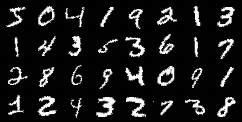

In [5]:
# we can show some samples
imgs = []
for img, _ in train_set:
    imgs.append(img.unsqueeze(0))
    if(len(imgs) == 4 * 8):
        break
_ = imshow(torchvision.utils.make_grid(torch.concat(imgs), nrows = 4))

---- [Epoch 0/5, Step 0/468] loss: 2039.708496----


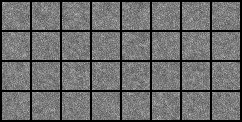

---- [Epoch 0/5, Step 156/468] loss: 744.994873----


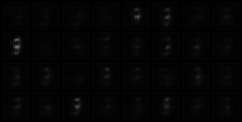

---- [Epoch 0/5, Step 312/468] loss: 729.338318----


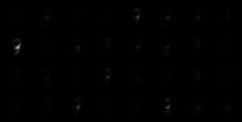

---- [Epoch 0/5, Step 467/468] loss: 731.092651----


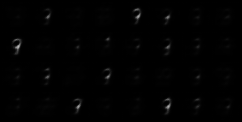

---- [Epoch 1/5, Step 0/468] loss: 731.132568----


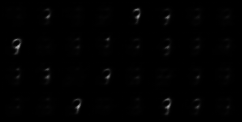

---- [Epoch 1/5, Step 156/468] loss: 725.584534----


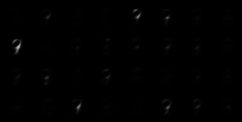

---- [Epoch 1/5, Step 312/468] loss: 725.482300----


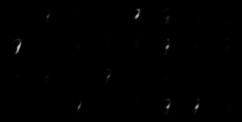

---- [Epoch 1/5, Step 467/468] loss: 725.260559----


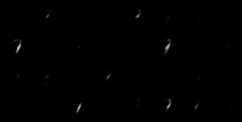

---- [Epoch 2/5, Step 0/468] loss: 723.810425----


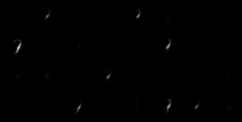

---- [Epoch 2/5, Step 156/468] loss: 723.261658----


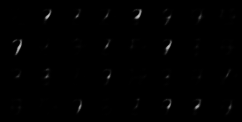

---- [Epoch 2/5, Step 312/468] loss: 723.330994----


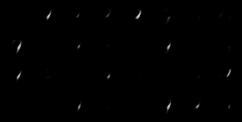

---- [Epoch 2/5, Step 467/468] loss: 720.394531----


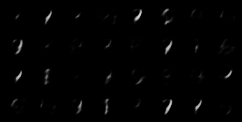

---- [Epoch 3/5, Step 0/468] loss: 721.163391----


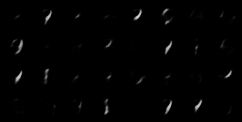

---- [Epoch 3/5, Step 156/468] loss: 721.462097----


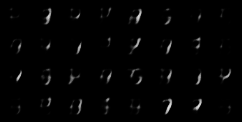

---- [Epoch 3/5, Step 312/468] loss: 719.330505----


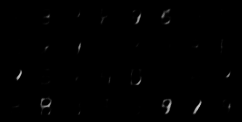

---- [Epoch 3/5, Step 467/468] loss: 712.662231----


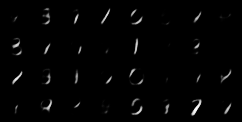

---- [Epoch 4/5, Step 0/468] loss: 715.543640----


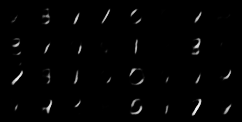

---- [Epoch 4/5, Step 156/468] loss: 710.441772----


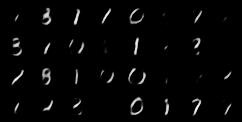

---- [Epoch 4/5, Step 312/468] loss: 710.675781----


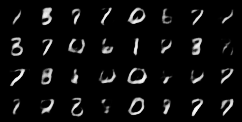

---- [Epoch 4/5, Step 467/468] loss: 712.954224----


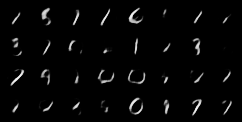

In [6]:
epochs = 5

z_dim = 112 # latent dimension of the NVAE
model = NVAE(z_dim=z_dim, forward_kl=False).to(device)
# spectral normalization
model.apply(add_sn)

zshow = torch.randn((batch_size,z_dim,2,2)).to(device)

optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

for epoch in range(epochs):
    model.train()

    for i, (image, _) in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        image_recon, recon_loss, kl_losses = model(image)

        beta = 1.
        loss = recon_loss + beta*torch.sum(torch.stack(kl_losses))
        loss.backward()
        optimizer.step()

        if i % 156 == 0 or i == len(train_loader) - 1:
            log_str = "\r---- [Epoch %d/%d, Step %d/%d] loss: %.6f----" % (
            epoch, epochs, i, len(train_loader), loss.item())
            print(log_str)
            with torch.no_grad():
                model.eval()
                _ = imshow(torchvision.utils.make_grid(model.decoder(zshow)[0], nrows = 4)[:, :122])
                model.train()
                
    scheduler.step()

---- [Epoch 0/5, Step 0/468] loss: 26321.650391----


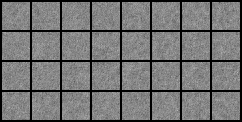

---- [Epoch 0/5, Step 156/468] loss: 754.784119----


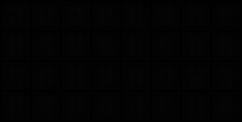

---- [Epoch 0/5, Step 312/468] loss: 737.588989----


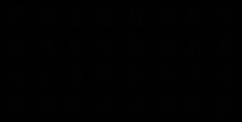

---- [Epoch 0/5, Step 467/468] loss: 734.574341----


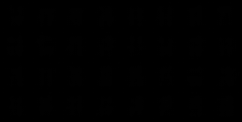

---- [Epoch 1/5, Step 0/468] loss: 732.589233----


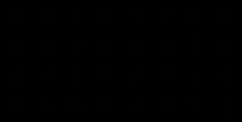

---- [Epoch 1/5, Step 156/468] loss: 729.436218----


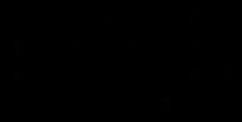

---- [Epoch 1/5, Step 312/468] loss: 728.590027----


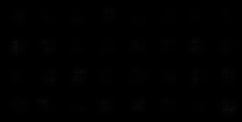

---- [Epoch 1/5, Step 467/468] loss: 729.072144----


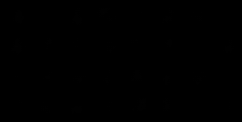

---- [Epoch 2/5, Step 0/468] loss: 728.106934----


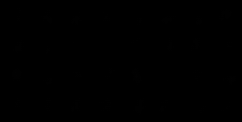

---- [Epoch 2/5, Step 156/468] loss: 727.309387----


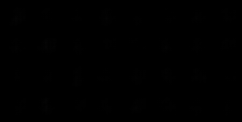

---- [Epoch 2/5, Step 312/468] loss: 727.548584----


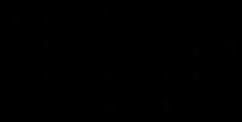

---- [Epoch 2/5, Step 467/468] loss: 726.851074----


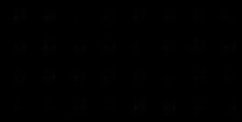

---- [Epoch 3/5, Step 0/468] loss: 725.940979----


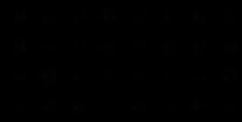

---- [Epoch 3/5, Step 156/468] loss: 725.353882----


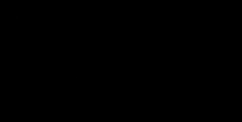

---- [Epoch 3/5, Step 312/468] loss: 724.488403----


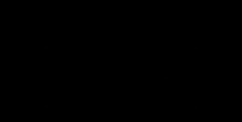

---- [Epoch 3/5, Step 467/468] loss: 725.117004----


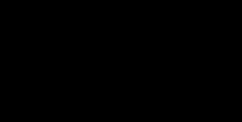

---- [Epoch 4/5, Step 0/468] loss: 726.562561----


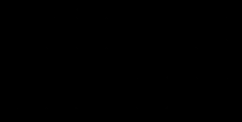

---- [Epoch 4/5, Step 156/468] loss: 724.171997----


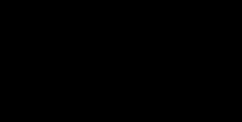

---- [Epoch 4/5, Step 312/468] loss: 727.079834----


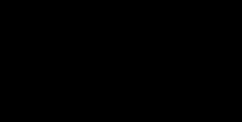

---- [Epoch 4/5, Step 467/468] loss: 726.464233----


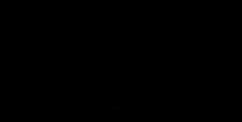

In [9]:
epochs = 5

z_dim = 112 # latent dimension of the NVAE
model = NVAE(z_dim=z_dim, forward_kl=True).to(device)
# spectral normalization
model.apply(add_sn)

zshow = torch.randn((batch_size,z_dim,2,2)).to(device)

optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-4)

for epoch in range(epochs):
    model.train()

    for i, (image, _) in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        image_recon, recon_loss, kl_losses = model(image)

        beta = 1.
        loss = recon_loss + beta*torch.sum(torch.stack(kl_losses))
        loss.backward()
        optimizer.step()

        if i % 156 == 0 or i == len(train_loader) - 1:
            log_str = "\r---- [Epoch %d/%d, Step %d/%d] loss: %.6f----" % (
            epoch, epochs, i, len(train_loader), loss.item())
            print(log_str)
            with torch.no_grad():
                model.eval()
                _ = imshow(torchvision.utils.make_grid(model.decoder(zshow)[0], nrows = 4)[:, :122])
                model.train()
                
    scheduler.step()

We observe that we can not get correct samples.